In [1]:
!pip install shap adjustText xgboost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math

from utilities.data import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

loader = DataLoader(use_data_pt2=True)
#grenade_df = loader.load_grenade_df(nrows=20000)
#print(grenade_df.info())
#print(grenade_df.isnull().sum())
#kill_df = loader.load_kill_df()
#print(kills_df.info())
#dmg_df = loader.load_dmg_df(nrows=20000)
#dmg_df = dmg_df[(~dmg_df['seconds'].isna())]
#print(dmg_df.info())
#print(dmg_df.isnull().sum())
results_df = loader.load_firefight_df(map_name='de_mirage')
print(results_df.info())
results_df = results_df[results_df['att_side'] != 'None']
results_df = results_df[results_df['seconds'] != 'None']
print(results_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271942 entries, 0 to 2271941
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   winner_side  object 
 1   att_side     object 
 2   map          object 
 3   seconds      float64
 4   pos_x        float64
 5   pos_y        float64
 6   hp_dmg       float64
 7   pos_type     object 
 8   index        int64  
 9   file_round   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 173.3+ MB
None
winner_side      0
att_side         0
map              0
seconds        500
pos_x            0
pos_y            0
hp_dmg           0
pos_type         0
index            0
file_round       0
dtype: int64
['CounterTerrorist' 'Terrorist']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2254374 entries, 0 to 2271941
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   winner_side  object 
 1   att_side     object 
 2   map          object 
 3   seconds      float64
 

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


winner_side      0
att_side         0
map              0
seconds        500
pos_x            0
pos_y            0
hp_dmg           0
pos_type         0
index            0
file_round       0
dtype: int64


min_samples: 80
CounterTerrorist, Smoke, de_mirage: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17]), array([26955, 73460, 57752, 35158, 14493,  5142,  1628,  4636,  3295,
         294,   188,   591,   995,   310,   545,   111,   196,   227,
          83]))
CounterTerrorist, HE, de_mirage: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), array([31800, 93927,  9175, 50228,  1384, 10286,   354,  9140,   592,
        1158,  1776,  3507,   149,  1137,   487,  1292,   217,   127,
         163,   145,   209,   166,    97,   124,    98,    83,    80]))
CounterTerrorist, Incendiary, de_mirage: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([29101, 73653, 18970, 72147, 10917,  7118, 25048,  3018,  8468,
        7510,  1458,  1277,   171,   180,   190,   414,   122,   213,
         205,   153

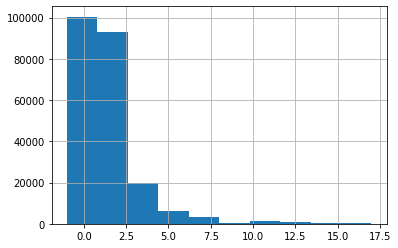

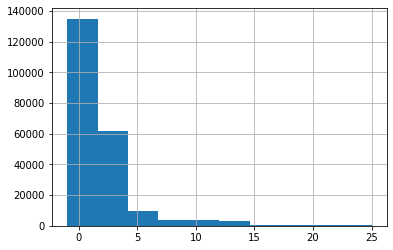

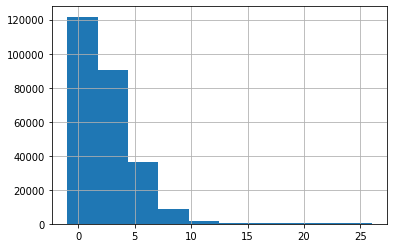

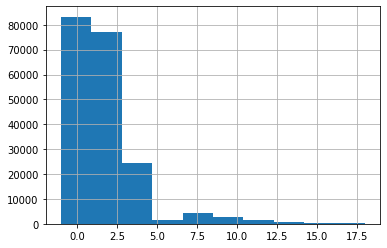

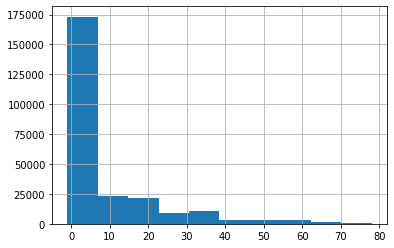

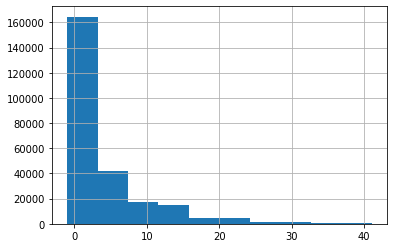

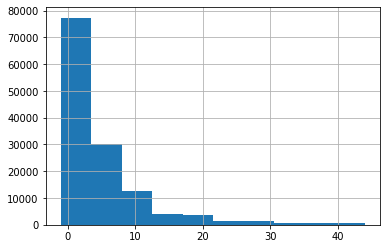

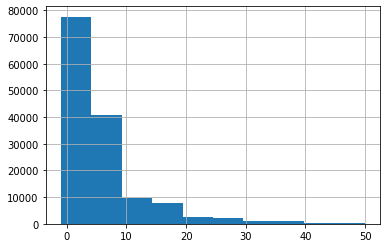

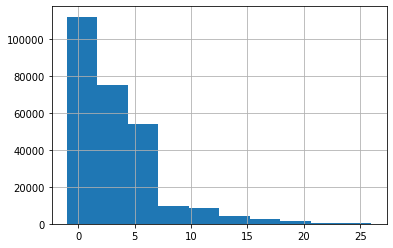

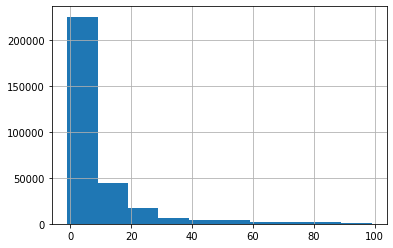

In [16]:
# Cluster spatially
from sklearn.cluster import DBSCAN
from collections import defaultdict
min_samples = 80
print(f"min_samples: {min_samples}")
unsupervised_models = {'DMG': DBSCAN(eps=0.003, min_samples=120),
                'Smoke': DBSCAN(eps=0.004, min_samples=min_samples), 
                'Flash': DBSCAN(eps=0.0036, min_samples=100), 
                'HE': DBSCAN(eps=0.004, min_samples=min_samples), 
                'Incendiary': DBSCAN(eps=0.004, min_samples=min_samples), 
                'Molotov': DBSCAN(eps=0.004, min_samples=min_samples)}
manual_models = defaultdict(lambda: MirageCalloutClusteringModel)
results_df = cluster_positions(results_df, unsupervised_models, verbose=True, scale=True)
print(results_df.isna().sum())
for team in results_df['att_side'].unique():
    for pos_type in results_df['pos_type'].unique():
        mask = (results_df['att_side'] == team)
        if pos_type == 'DMG_VIC':
            continue
        elif pos_type == 'DMG_ATT':
            mask = mask & ((results_df['pos_type'] == 'DMG_VIC') | (results_df['pos_type'] == 'DMG_ATT'))
        else:
            mask = mask & (results_df['pos_type'] == pos_type)
        clusters = results_df['pos_cluster'][mask]
        clusters.hist()
        plt.show()

In [17]:
# Do one-hot encoding for each team seperately and each type seperately (except DMG_VIC and DMG_ATT, which are done together)
pos_types = [t for t in results_df['pos_type'].unique() if t not in ['DMG_VIC', 'DMG_ATT']]
dummy_cols = []
for pos_type in pos_types:
    mask = (results_df['pos_type'] == pos_type)
    group = results_df[mask]
    # Differentiate T and CT cluster by adding max to all T
    max_ct_pos_cluster = group.loc[(group['att_side'] == 'CounterTerrorist'), 'pos_cluster'].max()
    group.loc[(group['att_side'] == "Terrorist"), 'pos_cluster'] += max_ct_pos_cluster*2
    dummies = pd.get_dummies(group['pos_cluster'])
    print(f"REAL COLS {dummies.columns}")
    dummies.columns = [f"CT_{pos_type}_{c}" if c <= max_ct_pos_cluster else f"T_{pos_type}_{c - max_ct_pos_cluster*2}" for c in dummies.columns]
    dummy_cols.extend(dummies.columns)
    for c in dummies.columns:
        results_df[c] = 0
    results_df.loc[mask, dummies.columns] = dummies
mask = (results_df['pos_type'] == 'DMG_ATT') | (results_df['pos_type'] == 'DMG_VIC')
group = results_df[mask]
max_ct_pos_cluster = group.loc[(group['att_side'] == 'CounterTerrorist'), 'pos_cluster'].max()
group.loc[(group['att_side'] == "Terrorist"), 'pos_cluster'] += max_ct_pos_cluster*2
dummies = pd.get_dummies(group['pos_cluster'])
dummies.columns = [f"CT_DMG_{c}" if c <= max_ct_pos_cluster else f"T_DMG_{c - max_ct_pos_cluster*2}" for c in dummies.columns]
dummy_cols.extend(dummies.columns)
for c in dummies.columns:
    results_df[c] = 0
results_df.loc[mask, dummies.columns] = dummies


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


REAL COLS Float64Index([-1.0,  0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0,
              10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 33.0, 34.0, 35.0,
              36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0,
              47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0,
              58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0,
              69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0],
             dtype='float64')
REAL COLS Float64Index([-1.0,  0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0,
              10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0,
              21.0, 22.0, 23.0, 24.0, 25.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0,
              55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0,
              66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0,
              77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0,
             

In [18]:
agg_fn = {c: 'sum' for c in dummy_cols}
pos_one_hot = results_df.groupby('file_round').agg(agg_fn)
meta_df = loader.load_meta_df()
meta_df["file_round"] = meta_df["file"] + "_" + meta_df["round"].astype(str)
meta_df = meta_df.drop(columns=['file', 'round'])
total_df = pd.merge(pos_one_hot, meta_df, how='left', left_index = True, right_on = 'file_round')

dummies = pd.get_dummies(total_df['round_type'])
total_df[dummies.columns] = dummies
print(total_df.head(10))
DF_CSV = "full_model_data_mirage.csv"
total_df.to_csv(DF_CSV)

     CT_Smoke_-1.0  CT_Smoke_0.0  CT_Smoke_1.0  CT_Smoke_2.0  CT_Smoke_3.0  \
93               0             1             1             0             0   
94               0             2             2             0             0   
95               0             0             0             0             0   
96               1             2             0             0             1   
97               1             1             1             0             0   
98               1             1             0             0             0   
99               0             0             1             0             0   
100              0             0             0             1             0   
101              0             0             1             1             0   
85               0             1             1             0             0   

     CT_Smoke_4.0  CT_Smoke_5.0  CT_Smoke_6.0  CT_Smoke_7.0  CT_Smoke_8.0  \
93              0             0             0             0     

RUNNING MODEL LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE: 0.3738021901747082
MSE: 0.18219732818333068
ROC AUC: 0.811325624279108
RUNNING MODEL RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
MAE: 0.33285088326184215
MSE: 0.17238575250219085
ROC AUC: 0.8221377710066357
RUNNING MODEL GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
   

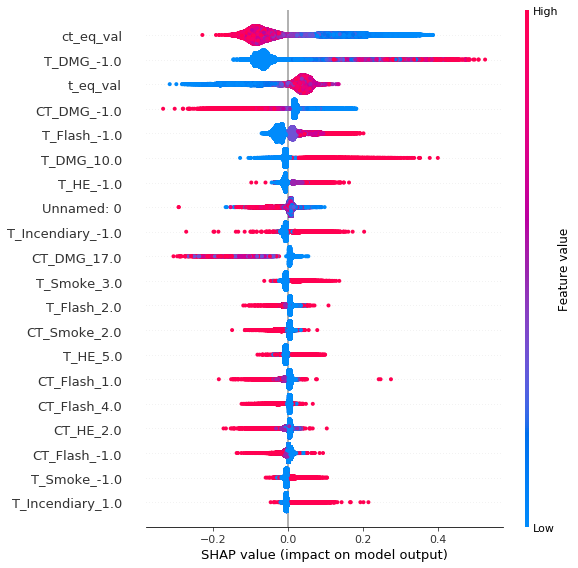

         col_name  feature_importance_vals   absvals
445     ct_eq_val                 0.005708  0.105183
344    T_DMG_-1.0                -0.005979  0.098136
446      t_eq_val                 0.002493  0.054947
264   CT_DMG_-1.0                 0.012892  0.028944
236  T_Flash_-1.0                 0.001059  0.028197


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import xgboost as xgb
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

def evaluate(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    print(f"ROC AUC: {roc_auc}")

def run_models(X, y, mod, tune_params=None, show_shap=False, scale=False):
    print(f"RUNNING MODEL {mod}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    mod.fit(X_train, y_train)
    evaluate(mod, X_test, y_test)
    

    if tune_params:
        print("TUNING...")
        # run randomized search
        rf_random = RandomizedSearchCV(estimator = mod, param_distributions = tune_params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        rf_random.fit(X_train, y_train)
        mod = rf_random.best_estimator_
        print(f"BEST MOD: {mod}")
        evaluate(mod, X_test, y_test)
        print("FEATURE IMPORTANCES:")
        sorted_idx = mod.feature_importances_.argsort()
        print([x for x in zip(X.columns[-sorted_idx], mod.feature_importances_[-sorted_idx])])

        #print("PERMUTATION IMPORTANCES:")
        #perm_importance = permutation_importance(mod, X_test, y_test)
        #sorted_idx = perm_importance.importances_mean.argsort()
        #print([x for x in zip(X.columns[-sorted_idx], perm_importance.importances_mean[-sorted_idx])])
    if show_shap:
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_train)
        shap.summary_plot(shap_values, X_train, feature_names=X.columns)
        return mod, shap_values
    return mod
DF_CSV = "full_model_data_mirage.csv"
total_df = pd.read_csv(DF_CSV)
X = total_df.drop(columns=['file_round', 'map', 'start_seconds', 'winner_side', 'round_type'])
#print((agg_results_df['att_side'] == 'Terrorist').astype(int)*2 - 1)
y =  (total_df['winner_side'] == 'Terrorist')
run_models(X, y, LinearRegression(), scale=True)
run_models(X, y, RandomForestRegressor(), scale=True)
# get the shap values of the dummy cols
run_models(X, y, GradientBoostingRegressor(), scale=True)
run_models(X, y, xgb.XGBRegressor(), scale=True)
_, shap_values = run_models(X, y, xgb.XGBRegressor(), show_shap=True)

vals= shap_values.mean(0)
absvals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals, absvals)),columns=['col_name','feature_importance_vals', 'absvals'])
feature_importance.sort_values(by=['absvals'],ascending=False,inplace=True)
print(feature_importance.head(5))

RUNNING MODEL MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
MAE: 0.36839389288066626
MSE: 0.218721438421976
ROC AUC: 0.7898140577162411
RUNNING MODEL MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, 

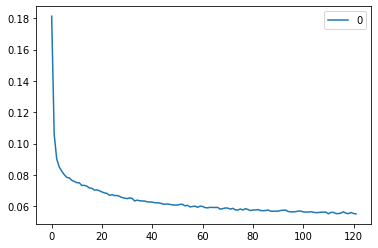

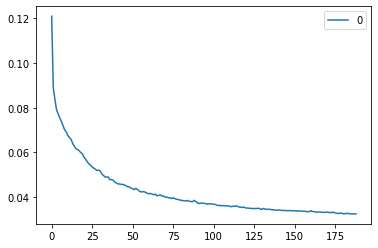

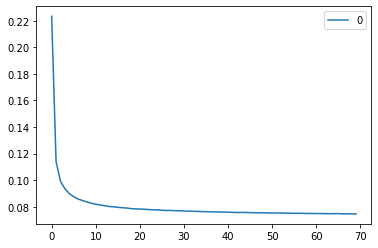

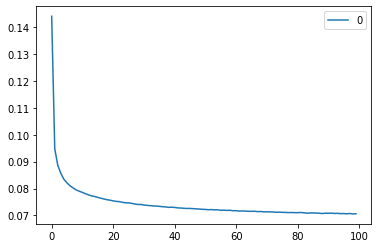

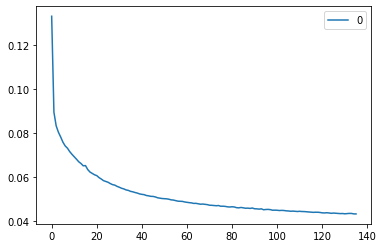

In [20]:
model = run_models(X, y, MLPRegressor(hidden_layer_sizes=(100,)), scale=True)
pd.DataFrame(model.loss_curve_).plot()
model = run_models(X, y, MLPRegressor(hidden_layer_sizes=(100,100,)), scale=True)
pd.DataFrame(model.loss_curve_).plot()
model = run_models(X, y, MLPRegressor(hidden_layer_sizes=(15,)), scale=True)
pd.DataFrame(model.loss_curve_).plot()
model = run_models(X, y, MLPRegressor(hidden_layer_sizes=(15,15)), scale=True)
pd.DataFrame(model.loss_curve_).plot()
model = run_models(X, y, MLPRegressor(hidden_layer_sizes=(100,15)), scale=True)
pd.DataFrame(model.loss_curve_).plot()

In [8]:
X_base = X[['ct_eq_val', 't_eq_val', 'ECO', 'FORCE_BUY', 'NORMAL', 'PISTOL_ROUND', 'SEMI_ECO']]
run_models(X_base, y, LinearRegression())
run_models(X_base, y, RandomForestRegressor())
run_models(X_base, y, GradientBoostingRegressor())
run_models(X_base, y, RandomForestRegressor())
run_models(X_base, y, xgb.XGBRegressor())
run_models(X_base, y, MLPRegressor(hidden_layer_sizes=(15,)))

RUNNING MODEL LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE: 0.4116115285620371
MSE: 0.20657473173837543
ROC AUC: 0.7395935480788731
RUNNING MODEL RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
MAE: 0.40968762351623467
MSE: 0.2602162374167786
ROC AUC: 0.6662809020808903
RUNNING MODEL GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
   

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(15,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

              col_name  feature_importance_vals   absvals
355         T_DMG_10.0                -0.000605  0.013805
282        CT_DMG_17.0                 0.001660  0.010504
24         T_Smoke_3.0                -0.000106  0.010469
239        T_Flash_2.0                 0.000444  0.009339
4         CT_Smoke_2.0                -0.001571  0.008964
96            T_HE_5.0                -0.000448  0.008921
218       CT_Flash_1.0                -0.000288  0.008639
221       CT_Flash_4.0                 0.000094  0.008027
66           CT_HE_2.0                -0.000352  0.007809
166   T_Incendiary_1.0                -0.000062  0.006754
347          T_DMG_2.0                -0.001956  0.006509
238        T_Flash_1.0                 0.000549  0.006217
353          T_DMG_8.0                -0.001277  0.006143
65           CT_HE_1.0                 0.000039  0.005853
22         T_Smoke_1.0                -0.000068  0.005310
139  CT_Incendiary_2.0                -0.000996  0.004894
274         CT

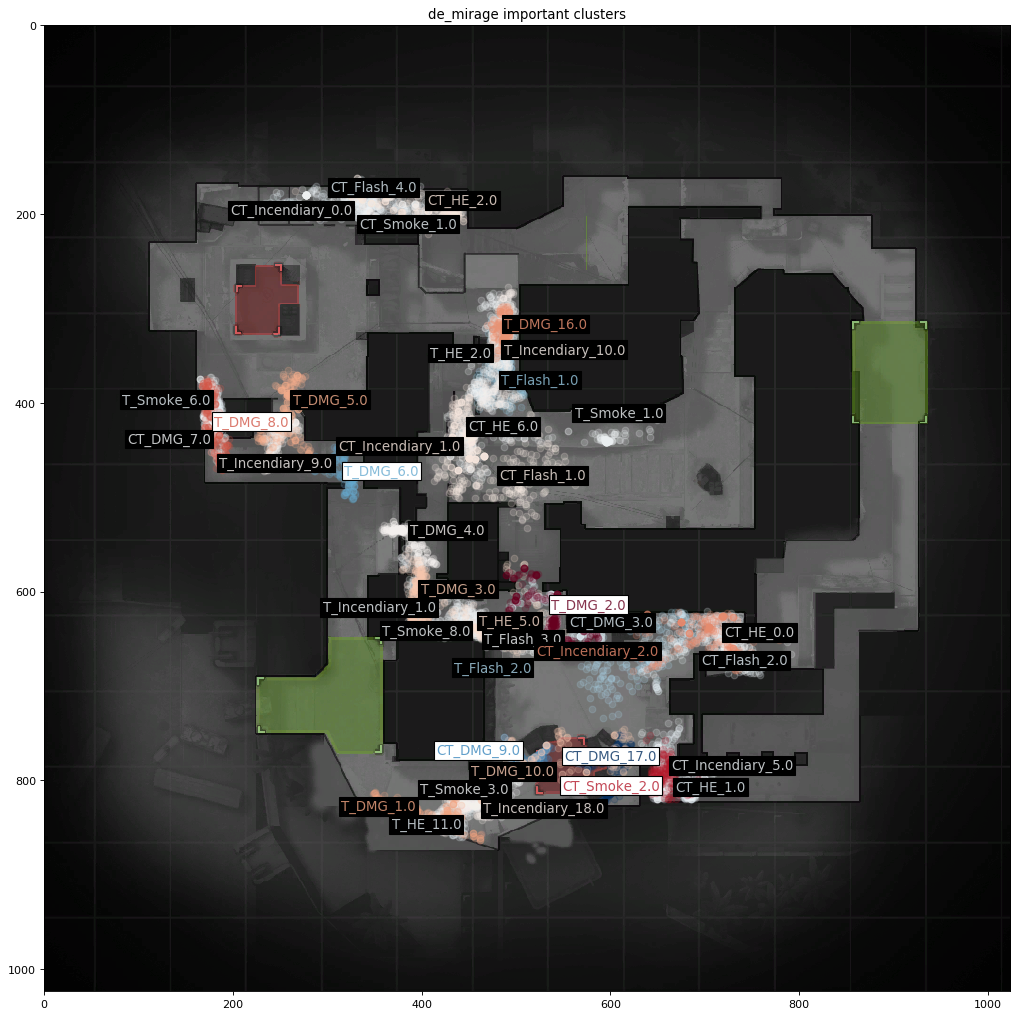

In [21]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
import matplotlib.cm as cm
from matplotlib.pyplot import figure
from adjustText import adjust_text
figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

def visualize_pos_clusters(cluster_df, map_name, clusters, shap_values):
    def centroid(x, y):
        length = x.shape[0]
        sum_x = np.sum(x)
        sum_y = np.sum(y)
        return sum_x/length, sum_y/length
    cluster_df = cluster_df[cluster_df['map'] == map_name]
    map_filenames = {map_name: f'../data/{map_name}.png' for map_name in cluster_df['map'].unique()}
    plt.title(f'{map_name} important clusters')
    im = plt.imread(map_filenames[map_name])
    plt.imshow(im)
    maxshap = np.max(shap_values)
    minshap = np.min(shap_values)
    shap_values = (shap_values - minshap) / (maxshap - minshap)
    texts = []
    for i, c in enumerate(clusters):
        df = cluster_df[(cluster_df[c] == 1)]
        print(df['pos_cluster'].unique())
        col = [cm.RdBu(shap_values[i])]
        plot_df = df[:200]
        plt.scatter(plot_df['pos_x'], plot_df['pos_y'], c=col, alpha=0.2)  
        bg_color = 'black' if 0.25 <= shap_values[i] <= 0.75 else 'white'
        bbox_props = bbox=dict(facecolor=bg_color, pad=2.0)
        cent = centroid(df['pos_x'], df['pos_y'])
        texts.append(plt.text(cent[0], cent[1], c, color=cm.RdBu(shap_values[i]), fontsize=12, alpha=0.8,  bbox=bbox_props))
        #plt.annotate(c, (cent[0] + np.random.normal()*25, cent[1] + np.random.normal()*25), color=cm.RdBu(shap_values[i]), fontsize=12, alpha=0.8, bbox=bbox_props)
    adjust_text(texts)
    plt.show()
    #'col_name','feature_importance_vals'
feature_importance = feature_importance[feature_importance['col_name'].str.contains("CT") | feature_importance['col_name'].str.contains("T")]
feature_importance = feature_importance[feature_importance['col_name'] != 'PISTOL_ROUND']
feature_importance = feature_importance[~feature_importance['col_name'].str.contains("-1")]
feature_importance = feature_importance[:40]
print(feature_importance)
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
print(feature_importance)

visualize_pos_clusters(results_df, 'de_mirage', feature_importance['col_name'], feature_importance['feature_importance_vals'].to_numpy())

Index(['Unnamed: 0', 'CT_Smoke_-1.0', 'CT_Smoke_0.0', 'CT_HE_-1.0',
       'CT_HE_0.0', 'CT_Incendiary_-1.0', 'CT_Incendiary_0.0', 'CT_Flash_-1.0',
       'CT_Flash_0.0', 'CT_DMG_-3.0', 'CT_DMG_-1.0', 'ct_eq_val', 't_eq_val',
       'ECO', 'FORCE_BUY', 'NORMAL', 'PISTOL_ROUND', 'SEMI_ECO'],
      dtype='object')
RUNNING MODEL GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=8,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=1313,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
M

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


BEST MOD: GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
MAE: 0.34543646600495476
MSE: 0.17172208485593154
ROC AUC: 0.821075555363032
FEATURE IMPORTANCES:
[('FORCE_BUY', 0.0026482693904611543), ('PISTOL_ROUND', 0.0033556912408974444), ('CT_DMG_-1.0', 0.12197332537911408), ('CT_Smoke_-1.0', 0.009888176566548251), ('CT_HE_0.0', 0.0007465586272419698), ('CT_Smoke_0.0', 0.0009226

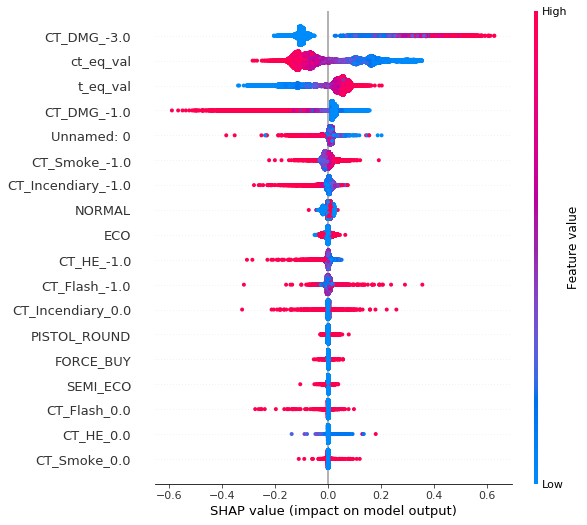

In [10]:
print(X.columns)
mod = run_models(X, y, GradientBoostingRegressor(min_samples_split=int(len(X)*.01), max_depth=8, max_features='sqrt', subsample=0.8), 
                 tune_params={'max_depth':range(5,16,2), 
                              'min_samples_split':range(10,100,10),
                              'learning_rate': np.arange(0.1, 1.0, 0.1),
                             'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 400, 800]},
                show_shap=True, scale=True)

RUNNING MODEL RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
MAE: 0.3490134218901343
MSE: 0.18138663807019975
ROC AUC: 0.8009278579354003
TUNING...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 123.4min finished


BEST MOD: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
MAE: 0.34191583965440153
MSE: 0.17176615695494657
ROC AUC: 0.8207398435157103
FEATURE IMPORTANCES:
[('CT_Smoke_0.0', 0.000664666141568795), ('FORCE_BUY', 0.0007794040805923889), ('CT_DMG_-1.0', 0.07487842240410761), ('CT_Smoke_-1.0', 0.010109780089190105), ('PISTOL_ROUND', 9.42361588310618e-05), ('CT_HE_0.0', 0.0001808387489305509), ('CT_HE_-1.0', 0.008445321098907187), ('t_eq_val', 0.16320046077353556), ('CT_Incendiary_-1.0', 0.012031781533802337), ('NORMAL', 0.0012334086611180757), ('ct_e

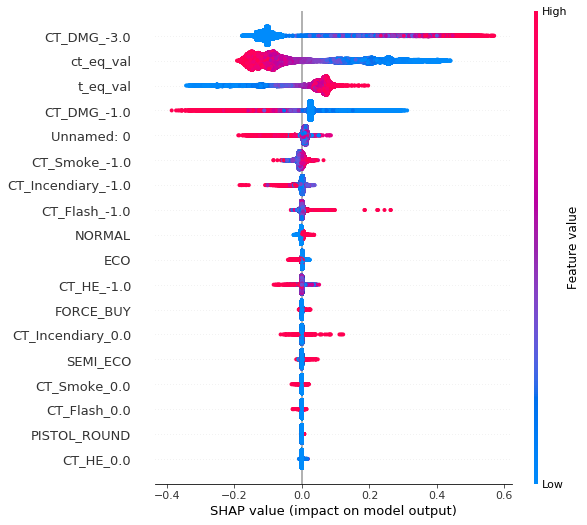

(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 array([[ 8.43281507e-03, -1.08597442e-02,  8.15289581e-05, ...,
         -1.96189785e-03, -7.94778426e-07,  6.57491866e-05],
        [-4.82998572e-02,  8.26283191e-03, -1.38923205e-04, ...,
         -1.96703297e-03, -3.53004640e-05,  6.04470997e-05],
        [ 6.42171649e-03, -9.36067223e-03, -1.21700941e-04, ...,
         -2.19520252e-03,  7.77703280e-05,  7.06767163e-06],
        ...,
        [ 1.28848308e-02, -5.95070977e-03,  2.97282968e-05, ...,
         -2.10829838e-03, -2.29826585e-05

In [ ]:
run_models(X, y, RandomForestRegressor(), tune_params={'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}, show_shap=True, scale=True)

In [ ]:
run_models(X, y, MLPRegressor(), tune_params={'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}, show_shap=True, scale=True)

RUNNING MODEL MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
MAE: 0.35092044443742704
MSE: 0.1737164787681052
ROC AUC: 0.8175087268114416
TUNING...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


ValueError: Invalid parameter n_estimators for estimator MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.